In [1]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')


import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications import resnet50
from keras.models import Model, load_model
from keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import cv2



In [2]:
for dirname, _, filenames in os.walk('./data'):
    print(dirname)

./data
./data\cell_images
./data\cell_images\Parasitized
./data\cell_images\Uninfected
./data\Parasitized
./data\Uninfected


In [3]:
def data_prep(parasitized, uninfected):
    
    parasitized = ["./data/Parasitized" + '/' +  parasitize for parasitize in parasitized]
    uninfected = ["./data/Uninfected" + '/' +  uninfect for uninfect in uninfected]

    labels = len(parasitized) * ['parasitized'] + len(uninfected) * ['uninfected']
    data = parasitized + uninfected

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})

In [4]:
df = data_prep(os.listdir("./data/Parasitized/"), os.listdir("./data/Uninfected/"))

In [5]:


print("Shape of the DataFrame:", df.shape)
print("\nHead of the DataFrame:")
print(df.head())
print("\nTail of the DataFrame:")
print(df.tail())



Shape of the DataFrame: (27558, 2)

Head of the DataFrame:
                                          Image_Path       Labels
0  ./data/Parasitized/C100P61ThinF_IMG_20150918_1...  parasitized
1  ./data/Parasitized/C100P61ThinF_IMG_20150918_1...  parasitized
2  ./data/Parasitized/C100P61ThinF_IMG_20150918_1...  parasitized
3  ./data/Parasitized/C100P61ThinF_IMG_20150918_1...  parasitized
4  ./data/Parasitized/C100P61ThinF_IMG_20150918_1...  parasitized

Tail of the DataFrame:
                                              Image_Path      Labels
27553  ./data/Uninfected/C99P60ThinF_IMG_20150918_142...  uninfected
27554  ./data/Uninfected/C99P60ThinF_IMG_20150918_142...  uninfected
27555  ./data/Uninfected/C99P60ThinF_IMG_20150918_142...  uninfected
27556  ./data/Uninfected/C99P60ThinF_IMG_20150918_142...  uninfected
27557  ./data/Uninfected/C99P60ThinF_IMG_20150918_142...  uninfected


In [6]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Function to load and preprocess images
def load_images(file_paths, target_size=(64, 64)):
    images = []
    for path in file_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, target_size)
        images.append(img)
    return np.array(images)

# Load and preprocess images
X = load_images(df['Image_Path'])
y = df['Labels']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build an improved CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))  
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
history = model.fit(X_train, (y_train == 'parasitized').astype(int), epochs=30, batch_size=32, validation_split=0.2)
print(history)


Epoch 1/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.6308 - loss: 0.7282 - val_accuracy: 0.6313 - val_loss: 1.1061
Epoch 2/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.9300 - loss: 0.2133 - val_accuracy: 0.9531 - val_loss: 0.1460
Epoch 3/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.9466 - loss: 0.1772 - val_accuracy: 0.9519 - val_loss: 0.1471
Epoch 4/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9491 - loss: 0.1588 - val_accuracy: 0.9567 - val_loss: 0.1269
Epoch 5/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - accuracy: 0.9555 - loss: 0.1474 - val_accuracy: 0.9580 - val_loss: 0.1243
Epoch 6/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 44s 79ms/step - accuracy: 0.9578 - loss: 0.1306 - val_accuracy: 0.5254 - val_loss: 0.6319
Epoch 7/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - accuracy: 0.9621 - loss: 0.1192 - val_accuracy: 0.9610 - val_loss: 0.1159
Epoch 8/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 44s 79ms/step - accuracy: 0.9634 - loss: 0.1124 - 

In [7]:

results = {
    'Kernel Type': [],
    'Accuracy': [],
    'F1 Score': [],
    'Precision': [],
    'Specificity': [],
}

# Extract features from the CNN model
cnn_features_train = model.predict(X_train)
cnn_features_test = model.predict(X_test)

# Reshape features for SVM
cnn_features_train_flat = cnn_features_train.reshape(
    cnn_features_train.shape[0], -1)
cnn_features_test_flat = cnn_features_test.reshape(
    cnn_features_test.shape[0], -1)

# List of kernel types
kernels = ['linear', 'poly', 'rbf']

# Train and evaluate SVM models for each kernel
for kernel_type in kernels:
    # Build an SVM model
    svm_model = SVC(kernel=kernel_type)
    svm_model.fit(cnn_features_train_flat, (y_train == 'parasitized'))

    # Predict using the SVM model
    svm_predictions = svm_model.predict(cnn_features_test_flat)
    y_pred = svm_model.predict(cnn_features_test_flat)

    # Evaluate the SVM model for each kernel
    accuracy = accuracy_score((y_test == 'parasitized'), svm_predictions)
    print(f"Accuracy of the SVM model (kernel: {kernel_type}): {accuracy*100}")
    accuracy = accuracy_score((y_test == 'parasitized'), y_pred)
    f1 = f1_score((y_test == 'parasitized'), y_pred)
    precision = precision_score((y_test == 'parasitized'), y_pred)
    conf_matrix = confusion_matrix((y_test == 'parasitized'), y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

    results['Kernel Type'].append(kernel_type)
    results['Accuracy'].append(accuracy)
    results['F1 Score'].append(f1)
    results['Precision'].append(precision)
    results['Specificity'].append(specificity)



689/689 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Accuracy of the SVM model (kernel: linear): 95.30116110304789
Accuracy of the SVM model (kernel: poly): 95.4644412191582
Accuracy of the SVM model (kernel: rbf): 95.44629898403484


(0.0, 1.0)

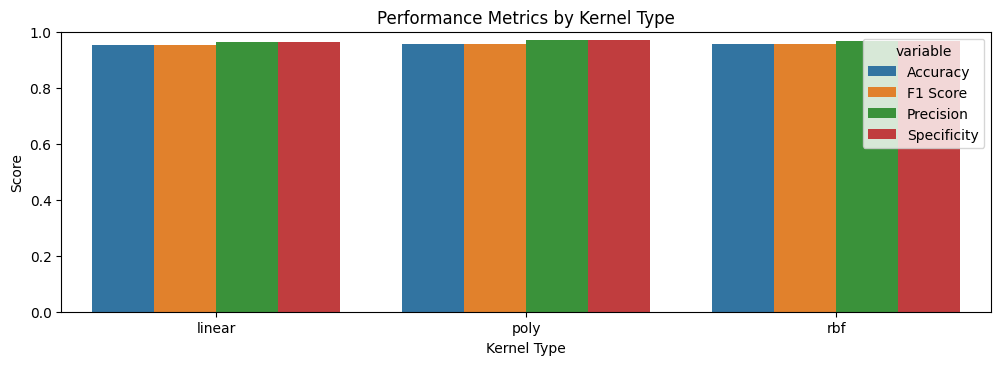

In [8]:
import pandas as pd
import seaborn as sns 

results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(12, 8))

# Bar plots for accuracy, F1 score, precision, and specificity
plt.subplot(2, 1, 1)
sns.barplot(x='Kernel Type', y='value', hue='variable',
            data=pd.melt(results_df, id_vars='Kernel Type',
                         value_vars=['Accuracy', 'F1 Score', 'Precision', 'Specificity']))
plt.title('Performance Metrics by Kernel Type')
plt.ylabel('Score')
plt.xlabel('Kernel Type')
plt.ylim(0, 1)


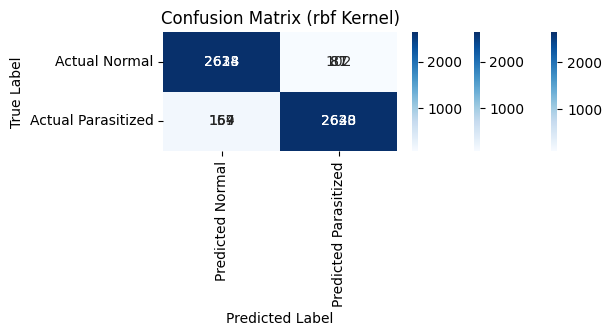

In [9]:
plt.subplot(2, 1, 2)
for kernel_type in kernels:
    # Build an SVM model
    svm_model = SVC(kernel=kernel_type)
    svm_model.fit(cnn_features_train_flat, (y_train == 'parasitized'))

    # Predict using the SVM model
    y_pred = svm_model.predict(cnn_features_test_flat)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix((y_test == 'parasitized'), y_pred)

    # Plot heatmap
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g',
                xticklabels=['Predicted Normal', 'Predicted Parasitized'],
                yticklabels=['Actual Normal', 'Actual Parasitized'])
    plt.title(f'Confusion Matrix ({kernel_type} Kernel)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

plt.show()
